In [15]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks
from tesser import figures

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

In [2]:
induct = tasks.load_induct(data_dir)
induct.head()

,subject,trial,trial_type,environment,community,cue,opt1,opt2,within,response,response_time,correct
0,100,1,central,ocean,1,2,16,20,2,NaN,NaN,NaN
1,100,2,boundary2,desert,2,4,10,19,1,2.0,2.974157,0.0
2,100,3,central,desert,2,5,6,2,1,1.0,3.190848,1.0
3,100,4,central,ocean,1,2,9,19,2,2.0,3.373906,1.0
4,100,5,central,ocean,1,1,19,13,1,2.0,3.094699,0.0


In [3]:
bias = (induct.groupby(['subject', 'trial_type'])[['correct']].mean() - .5) * 2
bias = bias.reset_index()

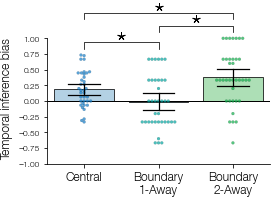

In [4]:
colors = figures.get_induct_colors()
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    bias,
    x='trial_type',
    y='correct',
    dark=colors['dark'],
    light=colors['light'],
    point_kws={'clip_on': False},
    ax=ax,
)
ax.set(
    ylim=(-1, 1), ylabel='Temporal inference bias',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
)
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k')
ax.set_xlim(*x_lim);
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = bias.groupby('trial_type')['correct'].max().to_list()
offset = 0.05 * np.diff(ax.get_ylim())
ax.set(ylim=(-1, 1.6), yticks=np.arange(-1, 1.25, .25))
ax.spines['left'].set_bounds(-1, 1)
statplot.plot_sig([x[0], x[1]], [y[0], y[1]], offset, ax=ax)
statplot.plot_sig([x[1], x[2]], [y[1], y[2]], offset, ax=ax)
statplot.plot_sig([x[0], x[2]], [y[0] + offset * 2, y[2] + offset * 2], offset, ax=ax)
ax.yaxis.set_label_coords(-.15, 0.4)
fig.savefig(os.path.join(fig_dir, 'temporal_bias.pdf'))

In [5]:
pg.rm_anova(data=bias, dv='correct', within='trial_type', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,trial_type,2,72,14.270354,0.000006,0.283872,0.88351


In [6]:
pg.pairwise_ttests(data=bias, dv='correct', within='trial_type', subject='subject', padjust='fdr_bh')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,trial_type,boundary1,boundary2,True,True,-4.735596,36.0,two-sided,0.000034,0.000101,fdr_bh,669.792,-0.909924
1,trial_type,boundary1,central,True,True,-3.297114,36.0,two-sided,0.002204,0.003306,fdr_bh,15.542,-0.546255
2,trial_type,boundary2,central,True,True,2.581411,36.0,two-sided,0.014059,0.014059,fdr_bh,3.14,0.528246


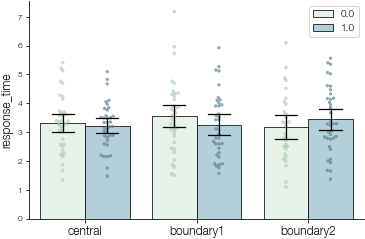

In [7]:
rt = induct.groupby(['trial_type', 'correct', 'subject'])['response_time'].mean()
rt = rt.reset_index()
statplot.plot_swarm_bar(
    rt,
    x='trial_type',
    y='response_time',
    hue='correct',
    dodge=True,
    bar_kws={'capsize': .2},
);

In [8]:
pg.rm_anova(
    data=rt,
    dv='response_time',
    subject='subject',
    within=['trial_type', 'correct']
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,trial_type,0.609876,2,72,0.304938,0.882899,0.418011,0.396771,0.023938,0.788443
1,correct,0.348010,1,36,0.348010,1.046539,0.313131,0.313131,0.028249,1.000000
2,trial_type * correct,2.424341,2,72,1.212170,4.327327,0.016800,0.021068,0.107305,0.884391


In [27]:
pg.rm_anova(
    data=rt.query('trial_type != "central"'),
    dv='response_time',
    subject='subject',
    within=['trial_type', 'correct']
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,trial_type,0.326897,1,36,0.326897,1.210815,0.278474,0.278474,0.032539,1.0
1,correct,0.153668,1,36,0.153668,0.394367,0.533976,0.533976,0.010836,1.0
2,trial_type * correct,2.411290,1,36,2.411290,6.935315,0.012376,0.012376,0.161529,1.0


In [10]:
corr = rt.query('correct == 0').copy()
pg.rm_anova(
    data=corr,
    dv='response_time',
    subject='subject',
    within='trial_type',
)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,trial_type,2,58,3.253333,0.045801,0.057636,0.100868,0.80442,False,0.756869,0.020244


In [17]:
corr

,trial_type,correct,subject,response_time
0,central,0.0,100,3.293758
1,central,0.0,101,3.572860
2,central,0.0,102,3.702281
3,central,0.0,103,2.751278
4,central,0.0,104,2.559821
...,...,...,...,...
180,boundary2,0.0,133,2.586076
181,boundary2,0.0,135,3.338403
182,boundary2,0.0,136,3.348357
183,boundary2,0.0,137,NaN


In [28]:
mc = pd.pivot(
    rt.query('correct == 1'),
    index='subject',
    columns='trial_type',
    values='response_time'
)
mi = pd.pivot(
    rt.query('correct == 0'),
    index='subject',
    columns='trial_type',
    values='response_time'
)
pg.ttest(mc['boundary1'], mc['boundary2'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.241191,36,two-sided,0.222562,"[-0.52, 0.12]",0.175719,0.359,0.180276


In [7]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.13.0

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

matplotlib: 3.4.1
tesser    : 0.1.0
scipy     : 1.4.1
mindstorm : 0.8.0
seaborn   : 0.11.1
pingouin  : 0.3.11
numpy     : 1.18.1

